# Preparing a Ground Truth Dataset for Localization

This notebook shows how the ground truth recordings are prepared for the paper: *Scalable Spike Source Localization in Extracellular Recordings using Amortized Variational Inference*.

For the data preparation, we perform the data augmentation described in the original manuscript. This data augmentation introduces "virtual" channels which exist outside of the MEA, in addition to the real, recording channels. We extract all "detected" events from a patch of channels near the soma of the firing neuron and then center the extracted data on the channel with the largest detected spike. This provides a realistic dataset for evaluating the performance our localization method.

We designed this notebook to be compatible with any ground truth dataset generated by [MEArec](https://github.com/alejoe91/MEArec), the extracellular dataset simulator we used for all of our simulated data analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(suppress=True)
import math
import itertools
import h5py
from collections import defaultdict
import ast
import spikeextractors as se
import spiketoolkit as st
import MEArec as mr
import h5py
from utility_functions import data_augmentation_functions_new

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

import urllib
from urllib.request import urlretrieve

Here you can download an example MEArec dataset that is 4.2gb. This example dataset is used throughout these notebooks

In [2]:
# #Example MEArec dataset to be downloaded (4.2gb)
# file_url = 'https://www.dropbox.com/s/1jolgsw5kgxmsd5/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5?dl=1'
# file_name = '/disk/scratch/cole/recordingsrecordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5'

# urllib.request.urlretrieve(file_url, file_name)

Here, the path to the MEArec recording and recording name are provided

In [3]:
recording_directory = '/disk/scratch/cole/recordings/'#'/disk/scratch/cole/recordings/'
recording_name = 'recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5'
save_directory = '/disk/scratch/cole/recordings/'

#
width = 40 # The distance from the channel with the largest amplitude spike for which channels are included in the constructed data (microns).
spike_jitter = 5 # The number of frames used to align the extracted waveforms. We search within +-5 frames of the ground truth spike time to find the true peak.
amp_jitter = 0 # The amplitude jitter hyperparameter (described in the manuscript)
save = True # Save the dataset to the save_directory if True
#For testing
num_spikes = 500

In [4]:
file_name = recording_directory + recording_name
print(file_name)
recgen = mr.load_recordings(recording_directory + recording_name)
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]

recording = se.MEArecRecordingExtractor(recording_directory + recording_name, locs_2d=False)
sorting = se.MEArecSortingExtractor(recording_directory + recording_name)
channel_positions = np.asarray(recording.get_channel_locations())

/disk/scratch/cole/recordings/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5


In [5]:
spike_times = []
neuron_ids = []
overlaps = []
for unit_id in sorting.get_unit_ids():
    spike_train = sorting.get_unit_spike_train(unit_id=unit_id)
    spike_times.extend(spike_train)
    neuron_ids.extend([unit_id]*len(spike_train))
    overlaps.extend(recgen.spiketrains[unit_id].annotations['overlap'])
sort_indices = np.argsort(spike_times)
spike_times = np.asarray(spike_times)[sort_indices]
neuron_ids = np.asarray(neuron_ids)[sort_indices]
overlaps = np.asarray(overlaps)[sort_indices]

#For testing
spike_times = spike_times[:num_spikes]
neuron_ids = neuron_ids[:num_spikes]
overlaps = overlaps[:num_spikes]

In [6]:
print(len(spike_times))
min_channels = []
for i, spike_time in enumerate(spike_times):
    if i % 100 == 0:
        print(float(i)/len(spike_times), '%')
    snippets = np.squeeze(recording.get_snippets(channel_ids=None, reference_frames=[spike_time], snippet_len=10),0)
    min_channel_id = np.argmin(np.min(snippets, 1))
    min_channels.append(min_channel_id)

500
0.0 %
0.2 %
0.4 %
0.6 %
0.8 %


We now pad the electrode positions with "virtual" channels that lie outside the bounds of the MEA

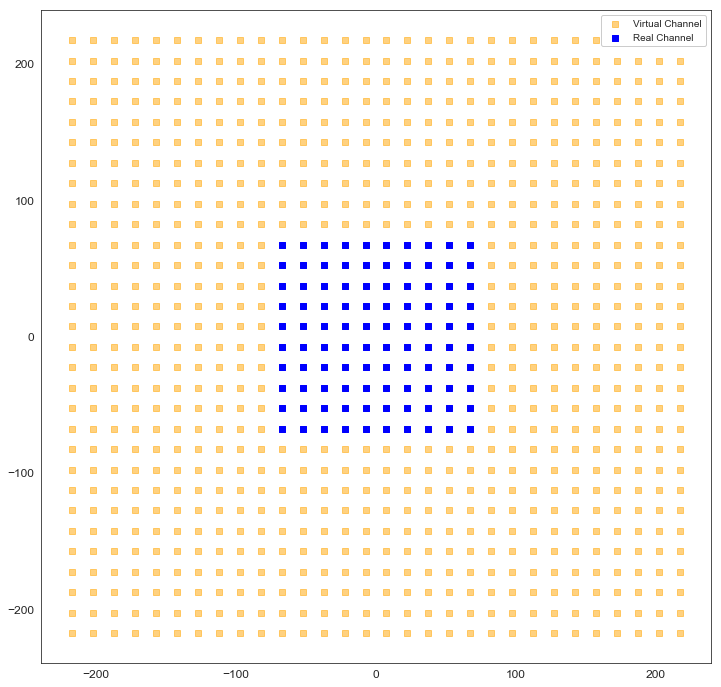

In [7]:
sorted_widths = np.unique(np.sort(channel_positions[:,1]))
buffer_height = sorted_widths[-1] + (-sorted_widths[0]) + (sorted_widths[-1] - sorted_widths[-2])
sorted_heights = np.unique(np.sort(channel_positions[:,2]))
buffer_width = sorted_heights[-1] + (-sorted_heights[0]) + (sorted_heights[-1] - sorted_heights[-2])

padded_channel_list = list(channel_positions)
for i in range(-1, 2):
    for j in range(-1, 2):
        if((i,j) != (0,0)):
            buffer_channel_y = channel_positions[:,1] + buffer_height*i
            buffer_channel_z = channel_positions[:,2] + buffer_width*j
            channel_positions_copy = np.copy(channel_positions)
            channel_positions_copy[:,1] += buffer_height*i
            channel_positions_copy[:,2] += buffer_width*j
            padded_channel_list = padded_channel_list + list(channel_positions_copy)

padded_channel_positions = np.asarray(padded_channel_list)

plt.figure(figsize=(12, 12))
plt.scatter(padded_channel_positions[:,1], padded_channel_positions[:,2], color='orange', marker='s', alpha=.5, label='Virtual Channel')
plt.scatter(channel_positions[:,1], channel_positions[:,2], color='blue', marker='s', label='Real Channel')
plt.legend(fancybox=True, framealpha=1);

Now, we extract all the waveforms for each event in the recording and compute the closest channels to each neuron for later use

In [8]:
# waveforms_all = []
# num_neurons = len(soma_positions)
# for neuron in range(num_neurons):  
#     waveforms = recgen.spiketrains[neuron].waveforms
#     waveforms_all.append(waveforms)

In [9]:
width_dist_channels = defaultdict(list)
channel_ids = recording.get_channel_ids()
for i, channel in enumerate(channel_ids):
    channel_ids_copy = np.copy(channel_ids)
    closest_channels = np.asarray(sorted(channel_ids, key=lambda channel_id: np.linalg.norm(channel_positions[channel_id] - channel_positions[channel])))
    for close_channel in closest_channels:
        if np.linalg.norm(channel_positions[close_channel] - channel_positions[channel]) < width:
            width_dist_channels[channel].append(close_channel)

Finally, we construct and save the augmented data in a format that can be used for our localization method. We also store the ground truth for later evaluation.

In [10]:
amps_list = []
channel_locations_list = []
center_location_list = []
central_channel_list = []
waveforms_list_list = []
peak_channel_list = []
spike_time_list = []
spike_id_list = []
spike_id = 0

neuron_locations_list = []
neuron_list = []
overlap_list = []

for i, min_channel in enumerate(min_channels):
    if i % (int(len(min_channels)/5)) == 0:
        print(float(i)/len(min_channels), '%')
        
    dists = []
    amps = []
    locations = []
    
    spike_time = spike_times[i]
    candidate_channels = np.asarray(width_dist_channels[min_channel])
    
    unit = neuron_ids[i]
    overlap = overlaps[i]
    waveforms = np.squeeze(recording.get_snippets(reference_frames=[spike_time], snippet_len=61), 0)
    peak_frames, peak_channels, peak_amps = data_augmentation_functions_new.get_peak_events(waveforms, candidate_channels, amp_jitter=amp_jitter,spike_jitter=spike_jitter)
    for i, peak_channel in enumerate(peak_channels):
        peak_frame = peak_frames[i]
        peak_amp = peak_amps[i]
        #Get a group of channels within the given width from the max channel
        square_channel_tuples, center_position = data_augmentation_functions_new.get_channel_square(peak_channel, padded_channel_positions, width=width)
        new_soma_pos = soma_positions[unit] - center_position

        #Construct augmented data dataset with virtual and real channels (take min of each real channel (jitter around peak))
        amps = []
        channel_locations = []
        waveforms_list = []
        #If all waveforms are positive, we discard the event (this happens incredibly rarely in ground truth data and almost never in real data).
        if(peak_amp < 0):
            for sct in square_channel_tuples:
                channel = sct[0]
                scaled_position = padded_channel_positions[channel] - center_position
                channel_x = scaled_position[0]
                channel_y = scaled_position[1]
                channel_z = scaled_position[2]
                if(channel < channel_positions.shape[0]):
                    #Real channel
                    observed = 1
                    #Get min peak within the spike jitter around the frame where the true minimum occurred
                    min_peak = np.min(waveforms[channel, peak_frame - spike_jitter:peak_frame + spike_jitter]) 
                    peak_reading = min_peak
                    waveforms_list.append(waveforms[channel,:])
                else:
                    #Virtual channel
                    observed = 0
                    #Virtual reading
                    peak_reading = 0
                    waveforms_list.append(np.zeros(len(waveforms[0,:])))
                #Calculate relative location compared to center position for channel
                channel_locations.append([channel_x, channel_y, channel_z])
                #Construct augmented amplitudes for channel
                amps.append((peak_reading, observed))
            #Model data
            waveforms_list_list.append(waveforms_list)
            amps_list.append(amps)
            channel_locations_list.append(channel_locations)
            center_location_list.append(list(center_position))
            peak_channel_list.append(peak_channel)
            spike_time_list.append(spike_time)
            spike_id_list.append(spike_id)
            central_channel_list.append(peak_channel)
            
            #Label data
            neuron_locations_list.append(list(new_soma_pos))
            neuron_list.append(unit)
            overlap_list.append(overlap)
        else:
            pass
    spike_id += 1
# ################################################################################## Save augmented data
if(save):
    channel_string = str(width) +"um"
    train_path = save_directory + 'model_data_gt_'+ channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name
    #Training data
    hf_train = h5py.File(train_path, 'w')
    hf_train.create_dataset('amps_list', data=amps_list)
    hf_train.create_dataset('channel_locations_list', data=channel_locations_list)
    hf_train.create_dataset('waveforms_list', data=waveforms_list_list)
    hf_train.create_dataset('center_location_list', data=center_location_list)
    hf_train.create_dataset('central_channel_list', data=central_channel_list)
    hf_train.create_dataset('spike_time_list', data=spike_time_list)
    hf_train.create_dataset('spike_id_list', data=spike_id_list)
    hf_train.close()

    #Training Labels
    label_path = save_directory + 'label_data_gt_' + channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name
    hf_label = h5py.File(label_path, 'w')
    hf_label.create_dataset('neuron_locations_list', data=neuron_locations_list)
    hf_label.create_dataset('neuron_list', data=neuron_list)
    overlap_list = [a.encode('utf8') for a in overlap_list]
    hf_label.create_dataset('overlap_list', data=overlap_list)
    hf_label.close()

    print("Train Path: " + train_path)
    print("Label Path: " + label_path)

0.0 %
0.2 %
0.4 %
0.6 %
0.8 %
Train Path: /disk/scratch/cole/recordings/model_data_gt_40um_VAE_0_amp_jitter_recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5
Label Path: /disk/scratch/cole/recordings/label_data_gt_40um_VAE_0_amp_jitter_recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5


Now, we can visualize examples for the augmented dataset to see how the data was prepared.

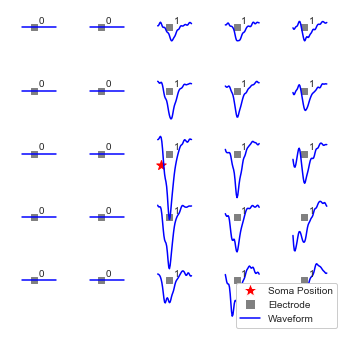

In [11]:
mid_frame = waveforms[0].shape[0]//2 # Middle frame of extracted waveform
cutout_start = 19 # Number of frames before peak to plot
cutout_end = 40 # Number of frames after peak to plot
neuron_id = 45 #Neuron ID for the example augmented data to be plotted

neuron_inds = []
for neuron in range(len(recgen.spiketrains)):
    neuron_inds.append(np.where(np.asarray(neuron_list)==neuron)[0][0])

event_id = neuron_inds[neuron_id]
amps = amps_list[event_id]
waveforms = np.asarray(waveforms_list_list[event_id])[:,mid_frame-cutout_start:mid_frame+cutout_end]
channel_locs = channel_locations_list[event_id]
neuron_loc = neuron_locations_list[event_id]
neuron = neuron_list[event_id]
center_loc = center_location_list[event_id]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(len(amps)):
    ax.scatter(channel_locs[i][1] + center_loc[1], channel_locs[i][2] + center_loc[2], s=30, c="grey", marker='s')
    readings = waveforms[i]
    xs = np.linspace(-2.5, 5, waveforms[i].shape[0])
    scaler = .1
    plt.plot(channel_locs[i][1] +  center_loc[1] + xs, channel_locs[i][2] + center_loc[2] + readings*.1, color='blue')
    observed = amps[i][1]
    text = ax.annotate(amps[i][1], (channel_locs[i][1] + center_loc[1] + 1, channel_locs[i][2] + center_loc[2] + 1))
    text.set_fontsize(10)
ax.scatter(neuron_loc[1] + center_loc[1], neuron_loc[2] + center_loc[2], s=100, marker='*', c="red")

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,# ticks along the top edge are off
    labelbottom=False,
    labelleft=False); # labels along the bottom edge are off

from matplotlib.lines import Line2D
ax.set_axis_off()
line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="red", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor="grey", markersize=10)
line3 = Line2D(range(1), range(1), color="blue", markerfacecolor="blue", markersize=12)

plt.legend((line1,line2,line3),('Soma Position','Electrode', 'Waveform'),numpoints=1, loc=4, framealpha=1);